## This notebook is the code-a-long from the video of Micrograd!

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [10]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

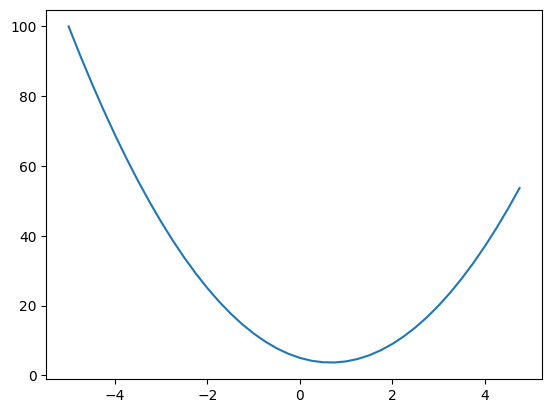

In [11]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [12]:
h = 0.0000000001
x = 2/3 
(f(x + h) - f(x))/h

0.0

In [13]:
# Lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [14]:
h = 0.00001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print(d1)
print(d2)
print('slope', (d2 - d1)/h)

4.0
3.9999699999999994
slope -3.000000000064062


### From here we start constructing micrograd ourself from scratch

In [15]:
class Value:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self ,other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(4)
d = a*b + c
d._op


'+'

In [21]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={"rankdir": "LR"}) # LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectengular node for it

        dot.node(name = uid, label = "{ data %.4f }" % (n.data, ), shape="record")
        if n._op:
            # if this value is a result of some operation then create a op node 
            dot.node(name = uid + n._op, labe = n._op)
            # and connect the node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

draw_dot(d)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH